## Libraries and Data Loading

In [1]:
import yaml
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import scipy.stats as stats
import torchaudio
import librosa

import importlib

import evaluation
importlib.reload(evaluation)
from evaluation import RunEval
from evaluation import LatexObject


run_path = "../logs/main_run/"
ex = RunEval(run_path)


## Code for Figures

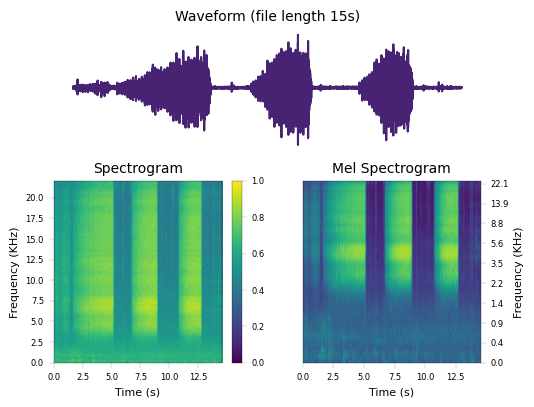

In [2]:
label = 'compare_spectrogram'
object_type = 'figure'
caption = 'Visualization of the two transformations of the audio signal.'
image_size_cm = [14, 11]

def create_object(image_size_cm=image_size_cm):
    index = 210 #43
    n_fft = 1024
    top_db = None

    metadata = ex.dataloader.dataset.get_metadata()

    waveform, sample_rate = ex.dataloader.dataset.load_sample(metadata['path'][index])

    def transform(waveform, sample_rate, n_mels, n_fft, top_db):
        if n_mels == -1:
            spec = torchaudio.transforms.Spectrogram(
                                                    n_fft=n_fft, 
                                                    hop_length=int(n_fft/2), 
                                                    win_length=n_fft)(waveform)
        else:
            spec = torchaudio.transforms.MelSpectrogram(
                                                    n_fft=n_fft,
                                                    hop_length=int(n_fft/2),
                                                    win_length=n_fft,
                                                    n_mels=n_mels)(waveform)
            
        db_spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)

        norm_db_spec = (db_spec - db_spec.min()) / (db_spec.max() - db_spec.min())

        return norm_db_spec


    fig = plt.figure(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))
    gs = fig.add_gridspec(2, 2, height_ratios=[4, 6], width_ratios=[6.5, 5.5])

    # upper plot
    ax_upper = fig.add_subplot(gs[0, :])
    time = np.arange(0, len(waveform[0])) / sample_rate
    ax_upper.plot(time, waveform[0], color='#482273')
    ax_upper.set_title(f'Waveform (file length {time.max():.0f}s)')
    # ax_upper.set_xlabel('Time [s]')
    # ax_upper.set_ylabel('Amplitude')

    # Remove y-axis and frame
    ax_upper.yaxis.set_visible(False)
    ax_upper.xaxis.set_visible(False)
    ax_upper.spines[['top', 'right', 'left', 'bottom']].set_visible(False)

    # lower plot

    for i, (title, n_mels) in enumerate(zip(
        ['Spectrogram', 'Mel Spectrogram'],
        [-1, 64])):

        spec = transform(waveform, sample_rate, n_mels, n_fft, top_db)

        # Convert frame indices to seconds
        hop_length = int(n_fft / 2)
        duration = waveform.shape[-1] / sample_rate
        time_bins = np.linspace(0, duration, spec.shape[-1])
        
        fig.add_subplot(gs[1, i])

        if n_mels == -1:
            # Frequency bins for the y-axis
            freq_bins = np.linspace(0, sample_rate // 2, spec.shape[0])
            freq_labels = [i for i in range(0, 20001, 2500)]

            plt.imshow(spec.numpy().squeeze(), origin='lower', aspect='auto', extent=[0, duration, 0, sample_rate // 2])
            plt.yticks(
                ticks=freq_labels,
                labels=[f'{freq / 1000:.1f}' for freq in freq_labels])
            
        elif n_mels == 64:
            mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=0, fmax=sample_rate // 2)
            plt.imshow(spec.numpy().squeeze(), origin='lower', aspect='auto', extent=[0, duration, 0, 64])

            num_ticks = 10
            tick_positions = np.linspace(0, n_mels-1, num_ticks).astype(int)
            tick_labels = [f'{mel_frequencies[i] / 1000:.1f}' for i in tick_positions]

            plt.yticks(tick_positions, tick_labels)
        
        plt.ylabel('Frequency (KHz)')
        plt.xlabel('Time (s)')
        plt.title(title)

        if i == 0:
            plt.colorbar()
        else:
            plt.gca().yaxis.tick_right()
            plt.gca().yaxis.set_label_position("right")
    
    return fig

compare_spectrogram = LatexObject(object_type=object_type, label=label, caption=caption, create_object=create_object)

compare_spectrogram.show()


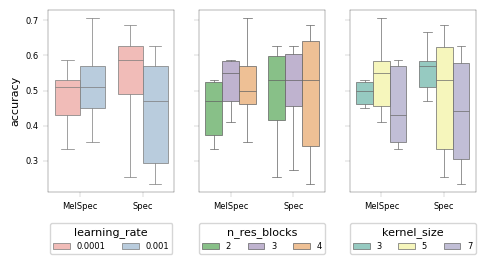

In [3]:
label = 'hyperparameters_boxplot'
object_type = 'figure'
caption = 'Accuracy of the models for different hyperparameter grouped by the transformation type.'
image_size_cm = [14, 6]

def create_object(image_size_cm=image_size_cm):
    fig, axes = plt.subplots(1, 3, figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54), sharex=True)

    for i, (hp, cmap) in enumerate(zip(
            ['learning_rate', 'n_res_blocks', 'kernel_size'],
            ['Pastel1', 'Accent', 'Set3'])):
        ax = axes[i]
        sns.boxplot(
            data=ex.get_summary(eval_subset=['validation']),
            x='transform',
            y='accuracy',
            whis=2,
            linewidth=0.5,
            fliersize=0.5,
            palette=cmap,
            hue=hp,
            ax=ax)
        
        ax.set_xlabel('')
        # sns.move_legend(ax, 'lower left', ncols=3)
        # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title=f'{hp}', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)


        if i > 0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
    
    return fig

hyperparameters_boxplot = LatexObject(object_type=object_type, label=label, caption=caption, create_object=create_object)

hyperparameters_boxplot.show()


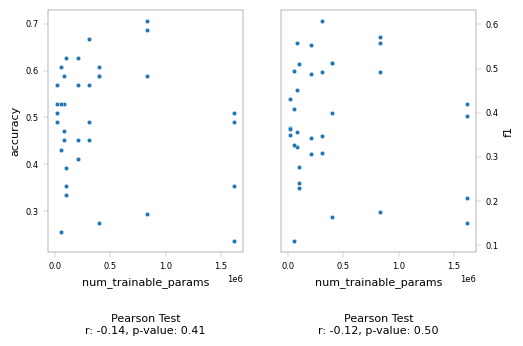

In [4]:
label = 'hyperparameters_scatterplot'
object_type = 'figure'
caption = 'Model size compared to the accuracy and F1 Score of the models.'
image_size_cm = [14, 8]

def create_object(image_size_cm=image_size_cm):
    fig, axes = plt.subplots(1, 2, figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54), sharex=True)

    data = ex.get_summary(eval_subset=['validation'])

    for i, metric in enumerate(['accuracy', 'f1']):

        pearson_corr, p_value = stats.pearsonr(data[metric], data['num_trainable_params'])

        ax = axes[i]
        sns.scatterplot(
            data=data,
            x='num_trainable_params',
            y=metric,
            s=10,
            ax=ax)
        
        if i > 0:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
        
        ax.text(0.5, -0.3, f'Pearson Test\nr: {pearson_corr:.2f}, p-value: {p_value:.2f}',
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    # sns.move_legend(ax, 'right', ncols=3)

    return fig

hyperparameters_scatterplot = LatexObject(object_type=object_type, label=label, caption=caption, create_object=create_object)

hyperparameters_scatterplot.show()

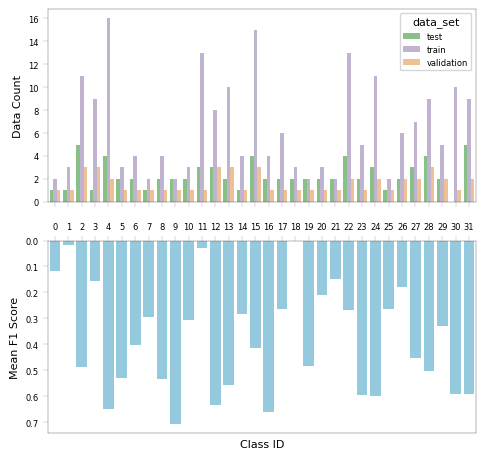

In [5]:
label = 'f1_per_class'
object_type = 'figure'
caption = 'F1 Score per class as mean trough all models compared to data distribution.'
image_size_cm = [14, 14]

def create_object(image_size_cm=image_size_cm):
    metadata = ex.dataloader.dataset.get_metadata()
    grouped = metadata.groupby(['class_id', 'data_set']).size().unstack(fill_value=0).reset_index()
    melted = grouped.melt(id_vars='class_id', var_name='data_set', value_name='count')

    f1_per_class = ex.get_metrics(sel_metric='f1_per_class', eval_subset=['validation']).mean()


    fig, axes = plt.subplots(2, 1, figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54), sharex=True)

    # Plot 1: Count of Class ID by Data Set
    sns.barplot(
        data=melted, 
        x='class_id', 
        y='count', 
        hue='data_set',
        palette = 'Accent', 
        ax=axes[0])
    axes[0].set_ylabel('Data Count')

    # Plot 2: Mean F1 Score per Class
    sns.barplot(
        data=f1_per_class,
        color = 'skyblue', 
        ax=axes[1]
    )
    axes[1].set_xlabel('Class ID')
    axes[1].set_ylabel('Mean F1 Score')

    # axes[1].xaxis.set_label_position('top')
    axes[1].xaxis.tick_top()
    axes[1].invert_yaxis()

    return fig

f1_per_class = LatexObject(object_type=object_type, label=label, caption=caption, create_object=create_object)

f1_per_class.show()

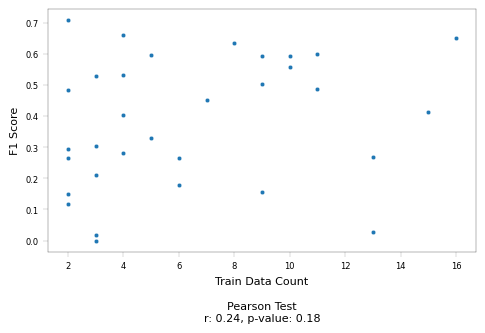

In [6]:
label = 'f1_per_class_to_data_distribution'
object_type = 'figure'
caption = 'Available training data per classes compared to the F1 Score per classes in a scatter plot and the result of the Pearson correlation test.'
image_size_cm = [14, 8]

def create_object(image_size_cm=image_size_cm):
    metadata = ex.dataloader.dataset.get_metadata()
    grouped = metadata.groupby(['class_id', 'data_set']).size().unstack(fill_value=0).reset_index()
    melted = grouped.melt(id_vars='class_id', var_name='data_set', value_name='count')


    f1_per_class = ex.get_metrics(
        sel_metric='f1_per_class', 
        eval_subset=['validation']
        ).mean().reset_index().rename(columns={'index': 'class_id', 0: 'f1'})
    f1_per_class

    f1_vs_data = melted.merge(f1_per_class, on='class_id', how='outer')

    

    fig, axes = plt.subplots(1, 1, figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54), sharey=True)



    data = f1_vs_data[f1_vs_data['data_set'] == 'train']

    pearson_corr, p_value = stats.pearsonr(data['f1'], data['count'])


    ax = axes
    sns.scatterplot(
        data=data,
        x='count',
        y='f1',
        s=10,
        ax=ax)
    ax.set_xlabel(f'Train Data Count')
    ax.set_ylabel(f'F1 Score')

    ax.text(0.5, -0.25, f'Pearson Test\nr: {pearson_corr:.2f}, p-value: {p_value:.2f}',
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


    return fig

f1_per_class_to_data_distribution = LatexObject(object_type=object_type, label=label, caption=caption, create_object=create_object)

f1_per_class_to_data_distribution.show()

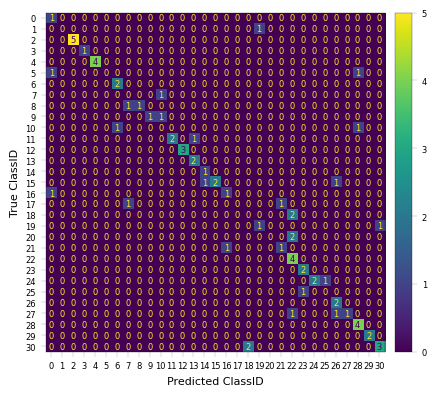

In [7]:
label = 'confusion_matrix_best'
object_type = 'figure'
caption = 'Confusion matrix for the predictions of the test set using the best model. The over all accuracy on the test set was ***.'
image_size_cm = [12, 12]

def calculate_caption_elements():
    _, accuracy = ex.get_best_model(sel_metric='accuracy', eval_subset=['test'])
    return round(accuracy, 3)

def create_object(image_size_cm=image_size_cm):
    index_best, _ = ex.get_best_model(eval_subset=['test'])

    y_true, y_pred = ex.get_predictions(index_best)
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)

    plt.setp(disp.ax_.texts, fontsize=6)

    # Label the axes
    ax.set_xlabel('Predicted ClassID')
    ax.set_ylabel('True ClassID')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    im = ax.imshow(cm, interpolation='nearest', cmap='viridis')
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params()

    return fig

confusion_matrix_best = LatexObject(object_type=object_type, label=label, caption=caption, create_object=create_object, calculate_caption_elements=calculate_caption_elements)

confusion_matrix_best.show()

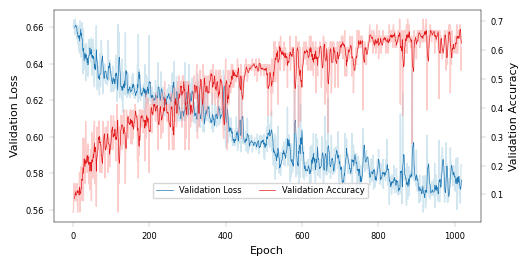

In [8]:
label = 'loss_acc_best'
object_type = 'figure'
caption = 'The validation loss and accuracy of the best model. Light version is not smoothed and dark version is smoothed with a window size of 5.'
image_size_cm = [14, 7]

def create_object(image_size_cm=image_size_cm):
    def smooth_data(data, window_size=5):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    index_best, _ = ex.get_best_model()
    metrics = ex.train_log[index_best]

    validation_data = metrics[~metrics['val_loss'].isnull()]

    # Smooth the data
    smoothed_val_loss = smooth_data(validation_data['val_loss'])
    smoothed_val_acc = smooth_data(validation_data['val_acc'])

    # Adjust the epoch range to match the length of the smoothed data
    epochs = validation_data['epoch'][len(validation_data['epoch']) - len(smoothed_val_loss):]

    fig, ax1 = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

    # Plot unsmoothed val_loss on the primary y-axis
    ax1.plot(validation_data['epoch'], validation_data['val_loss'], color='#A6CEE3', label='', linewidth=1, alpha=0.5)
    # Plot smoothed val_loss on the primary y-axis
    ax1.plot(epochs, smoothed_val_loss, color='#1F78B4', label='Validation Loss', linewidth=0.5)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Validation Loss')
    ax1.tick_params(axis='y')

    # Create a secondary y-axis to plot val_acc
    ax2 = ax1.twinx()
    # Plot unsmoothed val_acc on the secondary y-axis
    ax2.plot(validation_data['epoch'], validation_data['val_acc'], color='#FB9A99', label='', linewidth=1, alpha=0.5)
    # Plot smoothed val_acc on the secondary y-axis
    ax2.plot(epochs, smoothed_val_acc, color='#E31A1C', label='Validation Accuracy', linewidth=0.5)
    ax2.set_ylabel('Validation Accuracy')
    ax2.tick_params(axis='y')

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, 0.18), ncol=2)

    return fig

loss_acc_best = LatexObject(object_type=object_type, label=label, caption=caption, create_object=create_object)

loss_acc_best.show()

## Code for Tables

In [9]:
label = 'hyperparameters_results'
object_type = 'table'
caption = 'Results of the hyperparameter tuning by descending accuracy.'
table_size = 'scriptsize'

def create_object():
    data = ex.get_summary(eval_subset=['validation'])

    selection = ['n_mels', 'n_res_blocks', 'learning_rate', 'kernel_size', 'num_trainable_params', 'trained_epochs', 'accuracy', 'f1']

    data_selected = pd.DataFrame()

    for col in selection:
        if col in ['n_mels']:
            data_selected[col] = data[col].apply(lambda x: f"{x:.0f}")
        elif col in ['learning_rate']:
            data_selected[col] = data[col].apply(lambda x: f"{x:.3g}")
        elif col in ['accuracy', 'f1']:
            data_selected[col] = data[col].apply(lambda x: f"{x:.3f}")
        elif col in ['num_trainable_params']:
            data_selected[col] = data[col].apply(lambda x: f"{int(x):,}")
        else:
            data_selected[col] = data[col]

    # Convert DataFrame to LaTeX table
    latex_table = data_selected.to_latex(
        index=False, 
        column_format="rrrrrrrr"
    )

    # Manually replace the header row to make it bold
    old_header = "n_mels & n_res_blocks & learning_rate & kernel_size & num_trainable_params & trained_epochs & accuracy & f1 \\"
    new_header = "\\textbf{n\\_mels} & \\textbf{res blocks} & \\textbf{learning rate} & \\textbf{kernel size}& \\textbf{parameters} & \\textbf{epochs} & \\textbf{accuracy} & \\textbf{F1} \\"
    latex_table = latex_table.replace(old_header, new_header)
    
    return latex_table

hyperparameters_results = LatexObject(object_type=object_type, label=label, caption=caption, create_object=create_object, table_size=table_size)

hyperparameters_results.show()

\begin{tabular}{rrrrrrrr}
\toprule
\textbf{n\_mels} & \textbf{res blocks} & \textbf{learning rate} & \textbf{kernel size}& \textbf{parameters} & \textbf{epochs} & \textbf{accuracy} & \textbf{F1} \\
\midrule
64 & 4 & 0.001 & 5 & 832,912 & 1018 & 0.706 & 0.571 \\
-1 & 4 & 0.0001 & 5 & 832,912 & 672 & 0.686 & 0.557 \\
-1 & 4 & 0.0001 & 3 & 310,544 & 891 & 0.667 & 0.608 \\
-1 & 3 & 0.001 & 5 & 207,376 & 394 & 0.627 & 0.553 \\
-1 & 2 & 0.0001 & 7 & 96,528 & 1198 & 0.627 & 0.511 \\
-1 & 2 & 0.001 & 5 & 50,256 & 640 & 0.608 & 0.495 \\
-1 & 3 & 0.0001 & 7 & 401,104 & 760 & 0.608 & 0.512 \\
-1 & 3 & 0.0001 & 3 & 78,224 & 897 & 0.588 & 0.558 \\
64 & 4 & 0.0001 & 5 & 832,912 & 371 & 0.588 & 0.491 \\
64 & 3 & 0.0001 & 7 & 401,104 & 536 & 0.588 & 0.513 \\
64 & 3 & 0.001 & 7 & 401,104 & 350 & 0.588 & 0.399 \\
64 & 3 & 0.001 & 5 & 207,376 & 505 & 0.569 & 0.488 \\
-1 & 2 & 0.001 & 3 & 19,408 & 469 & 0.569 & 0.431 \\
-1 & 4 & 0.001 & 3 & 310,544 & 562 & 0.569 & 0.493 \\
64 & 3 & 0.0001 & 3 & 78,224 & 1

In [10]:
label = 'ClassID_legend'
object_type = 'table'
caption = 'ClassID legend.'
table_size = 'scriptsize'

def create_object():
    metadata = ex.dataloader.dataset.get_metadata()
    unique_class_id = metadata[['class_id', 'species']].drop_duplicates(subset=['class_id']).sort_values(by='class_id')

    # Split data into two parts
    half = len(unique_class_id) // 2 + len(unique_class_id) % 2
    first_half = unique_class_id.iloc[:half].reset_index(drop=True)
    second_half = unique_class_id.iloc[half:].reset_index(drop=True)

    # Concatenate first half and second half side by side
    concatenated = pd.concat([first_half, second_half], axis=1)

    # Adjust column names for LaTeX output
    concatenated.columns = ['ClassID', 'Species', 'ClassID', 'Species']

    # Convert to LaTeX
    latex_table = concatenated.to_latex(
        index=False, 
        column_format="rlrl",
        header=True
    )

    return latex_table

ClassID_legend = LatexObject(object_type=object_type, label=label, caption=caption, create_object=create_object, table_size=table_size)

ClassID_legend.show()

\begin{tabular}{rlrl}
\toprule
ClassID & Species & ClassID & Species \\
\midrule
0 & Azanicadazuluensis & 16 & Platypleurachalybaea \\
1 & Brevisianabrevis & 17 & Platypleuradeusta \\
2 & Chorthippusbiguttulus & 18 & Platypleuradivisa \\
3 & Chorthippusbrunneus & 19 & Platypleurahaglundi \\
4 & Grylluscampestris & 20 & Platypleurahirtipennis \\
5 & Kikihiamuta & 21 & Platypleuraintercapedinis \\
6 & Myopsaltaleona & 22 & Platypleuraplumosa \\
7 & Myopsaltalongicauda & 23 & Platypleurasp04 \\
8 & Myopsaltamackinlayi & 24 & Platypleurasp10 \\
9 & Myopsaltamelanobasis & 25 & Platypleurasp11cfhirtipennis \\
10 & Myopsaltaxerograsidia & 26 & Platypleurasp12cfhirtipennis \\
11 & Nemobiussylvestris & 27 & Platypleurasp13 \\
12 & Oecanthuspellucens & 28 & Pseudochorthippusparallelus \\
13 & Pholidopteragriseoaptera & 29 & Pycnasemiclara \\
14 & Platypleuracapensis & 30 & Roeselianaroeselii \\
15 & Platypleuracfcatenata & 31 & Tettigoniaviridissima \\
\bottomrule
\end{tabular}



In [13]:
LatexObject.export_all()